In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:

orders = pd.read_csv('olist_orders_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')
items = items.drop(items.columns[[2,3,4]], axis=1)
orders = orders.drop(orders.columns[[2,4,5,6,7]], axis=1)
items_all = items.groupby('order_id').agg({'price': 'sum', 'freight_value': 'sum'}).reset_index()
items_all['price'] = items_all.apply(lambda row: row['price'] + row['freight_value'], axis=1)
items_all.drop(columns=['freight_value'], inplace=True)
items_all.head()
print(len(orders))
print(len(items_all))
# print(type(orders))
# print(orders.head())
# print(type(orders['order_purchase_timestamp'][1]))
# orders['order_purchase_timestamp']

99441
98666


In [3]:
orders_data = pd.merge(items_all, orders, on='order_id', how='inner')
orders_data.head()
# len(orders_data)

,order_id,price,customer_id,order_purchase_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,72.19,3ce436f183e68e07877b285a838db11a,2017/9/13 8:59
1,00018f77f2f0320c557190d7a144bdd3,259.83,f6dd3ec061db4e3987629fe6b26e5cce,2017/4/26 10:53
2,000229ec398224ef6ca0657da4fc703e,216.87,6489ae5e4333f3693df5ad4372dab6d3,2018/1/14 14:33
3,00024acbcdf0a6daa1e931b038114c75,25.78,d4eb9395c8c0431ee92fce09860c5a06,2018/8/8 10:00
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04,58dbd0b2d70206bf40e62cd34e84d795,2017/2/4 13:57


count    98666.000000
mean       160.577638
std        220.466087
min          9.590000
25%         61.980000
50%        105.290000
75%        176.870000
max      13664.080000
Name: price, dtype: float64


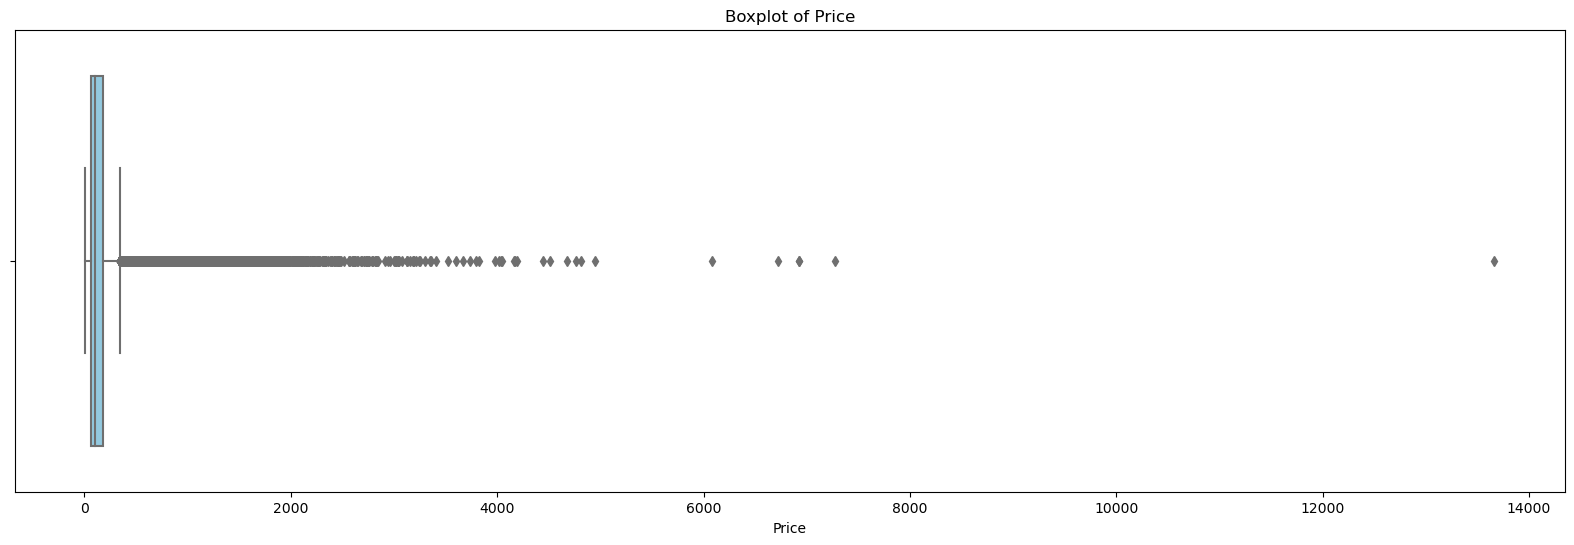

箱线图的最大值（maximum）: 349.20500000000004


In [4]:
print(orders_data['price'].describe())
plt.figure(figsize=(20, 6))
sns.boxplot(x=orders_data['price'], color='skyblue')

# 添加标题和标签
plt.title('Boxplot of Price')
plt.xlabel('Price')

# 显示图形
plt.show()
# 计算第一四分位数（Q1）
Q1 = orders_data['price'].quantile(0.25)

# 计算第三四分位数（Q3）
Q3 = orders_data['price'].quantile(0.75)

# 计算四分位距（IQR）
IQR = Q3 - Q1

# 计算最大值（maximum）
maximum = Q3 + 1.5 * IQR

print("箱线图的最大值（maximum）:", maximum)

In [5]:
# 找出比305.9大的price的数量
count_greater_than_305_9 = orders_data[orders_data['price'] > 305.9]['price'].count()

print("大于 Q3 + 1.5 * IQR 的比例：{:.2f}".format(count_greater_than_305_9 / len(orders_data['price']) * 100), "%")


大于 Q3 + 1.5 * IQR 的比例：10.09 %


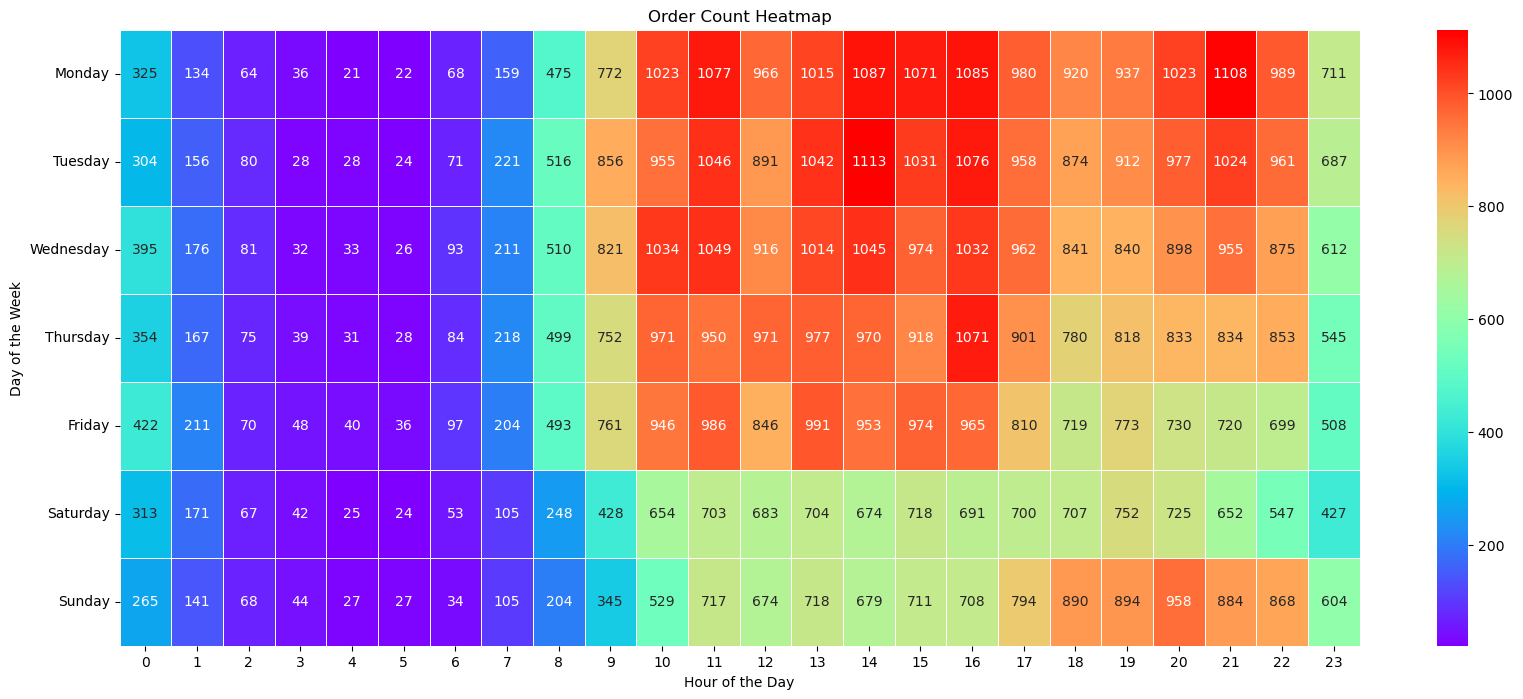

In [6]:
# 这2个heatmap和后面的画的是同一个东西，但是这个没有去掉“黑五”这个异常值，不过最后的结果看起来差不多
orders_data['order_purchase_timestamp'] = pd.to_datetime(orders_data['order_purchase_timestamp'])

# 提取星期几信息（0代表星期一，6代表星期天），和小时信息
orders_data['weekday'] = orders_data['order_purchase_timestamp'].dt.dayofweek
orders_data['hour'] = orders_data['order_purchase_timestamp'].dt.hour

# 按星期和小时计算订单数量
orders_count = orders_data.groupby(['weekday', 'hour']).size().unstack()

# 绘制热力图
plt.figure(figsize=(20, 8))
sns.heatmap(orders_count, cmap="rainbow", annot=True, fmt="d", linewidths=.5)
plt.title('Order Count Heatmap')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.xticks(np.arange(24) + 0.5, range(24))
plt.yticks(np.arange(7) + 0.5, ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=0)
plt.show()


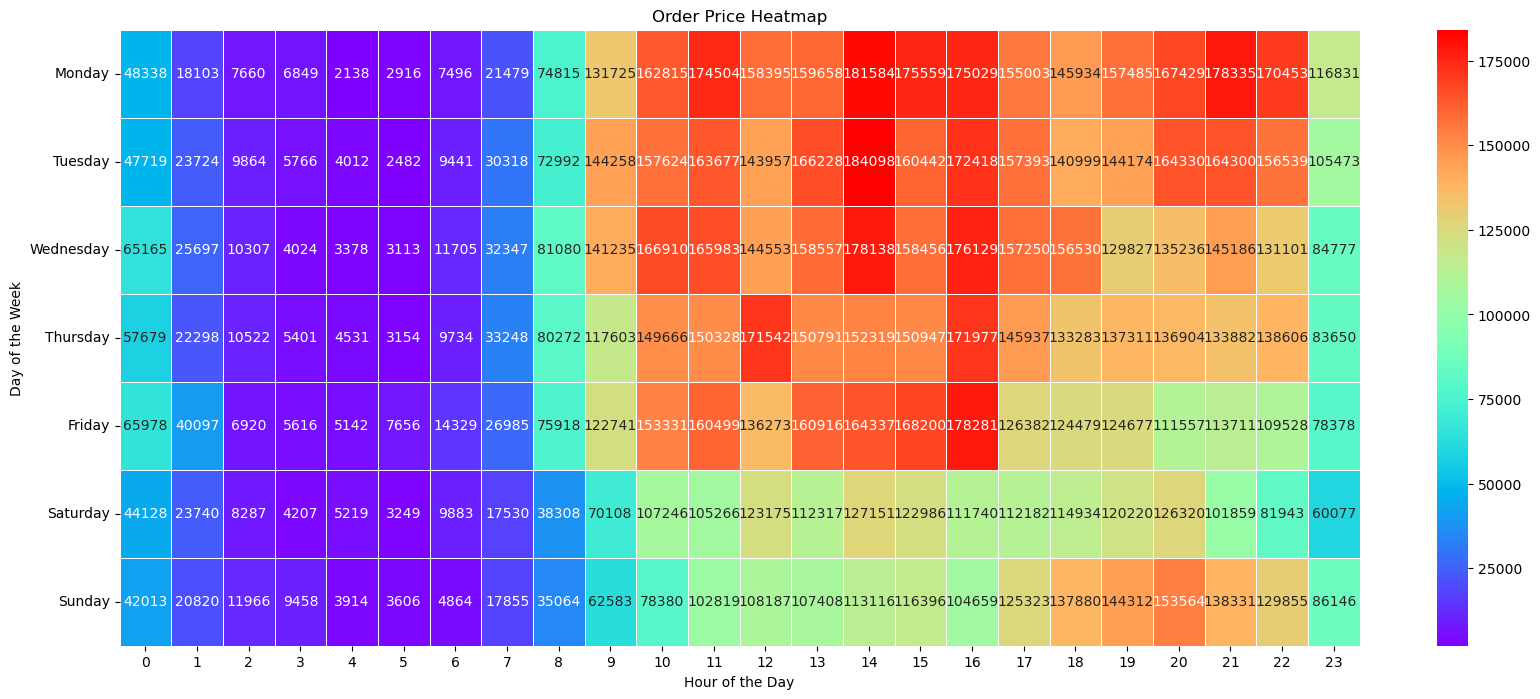

In [7]:

# 将 order_purchase_timestamp 列转换为 datetime 类型
orders_data['order_purchase_timestamp'] = pd.to_datetime(orders_data['order_purchase_timestamp'])

# 提取星期几信息（0代表星期一，6代表星期天），和小时信息
orders_data['weekday'] = orders_data['order_purchase_timestamp'].dt.dayofweek
orders_data['hour'] = orders_data['order_purchase_timestamp'].dt.hour

# 按星期和小时计算订单金额
orders_price = orders_data.groupby(['weekday', 'hour'])['price'].sum().unstack()

# 绘制热力图
plt.figure(figsize=(20, 8))
sns.heatmap(orders_price, cmap="rainbow", annot=True, fmt=".0f", linewidths=.5)
plt.title('Order Price Heatmap')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.xticks(np.arange(24) + 0.5, range(24))
plt.yticks(np.arange(7) + 0.5, ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=0)
plt.show()


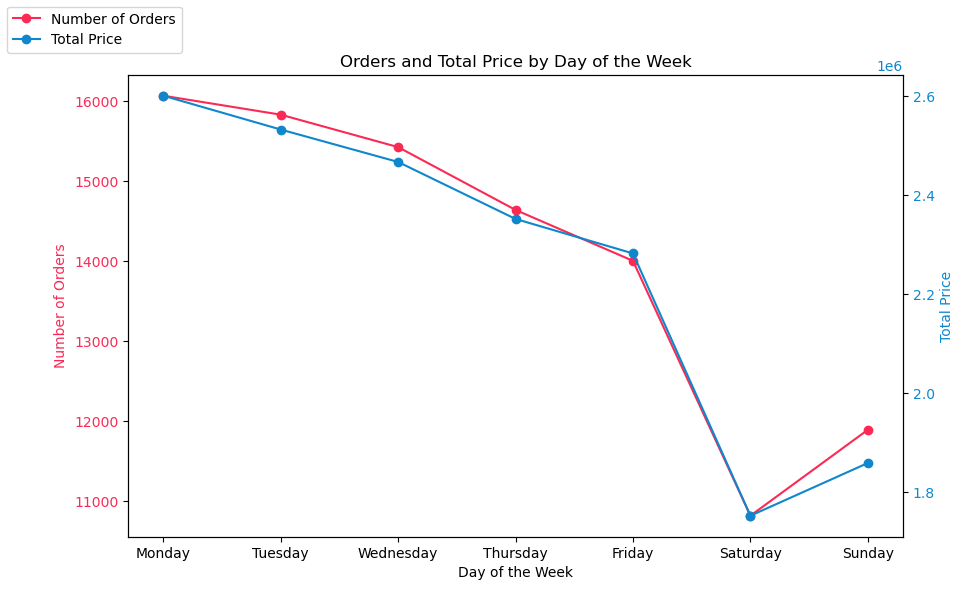

In [8]:
# 将 order_purchase_timestamp 列转换为 datetime 类型
orders_data['order_purchase_timestamp'] = pd.to_datetime(orders_data['order_purchase_timestamp'])

# 提取星期几信息（0代表星期一，6代表星期天）
orders_data['weekday'] = orders_data['order_purchase_timestamp'].dt.dayofweek

# 按照星期几计算订单数量和每天价格之和
weekday_stats = orders_data.groupby('weekday').agg({'price': 'sum', 'order_purchase_timestamp': 'count'})
weekday_stats = weekday_stats.rename(columns={'order_purchase_timestamp': 'number_of_orders'})

# 重新排序，使得星期一至星期日排在一周内的顺序
weekday_stats = weekday_stats.reindex([0, 1, 2, 3, 4, 5, 6])

# 创建画布和坐标轴
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制订单数量折线图
color = '#fa2a55'
ax1.plot(range(7), weekday_stats['number_of_orders'], marker='o', color=color, label='Number of Orders')
ax1.set_xlabel('Day of the Week')
ax1.set_ylabel('Number of Orders', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(7))
ax1.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# 在折线上标注数值
# for i, value in enumerate(weekday_stats['number_of_orders']):
#     ax1.text(i, value, round(value, 2), ha='center', va='bottom')

# 创建第二个坐标轴，共享x轴
ax2 = ax1.twinx()

# 绘制价格总和折线图
color = '#0e87cc'
ax2.plot(range(7), weekday_stats['price'], marker='o', color=color, label='Total Price')
ax2.set_ylabel('Total Price', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# 在折线上标注数值
# for i, value in enumerate(weekday_stats['price']):
#     ax2.text(i, value, round(value, 2), ha='center', va='bottom')

# 设置标题
plt.title('Orders and Total Price by Day of the Week')

# 移动图例到左下角
fig.legend(loc='upper left')

# 显示图形
plt.show()


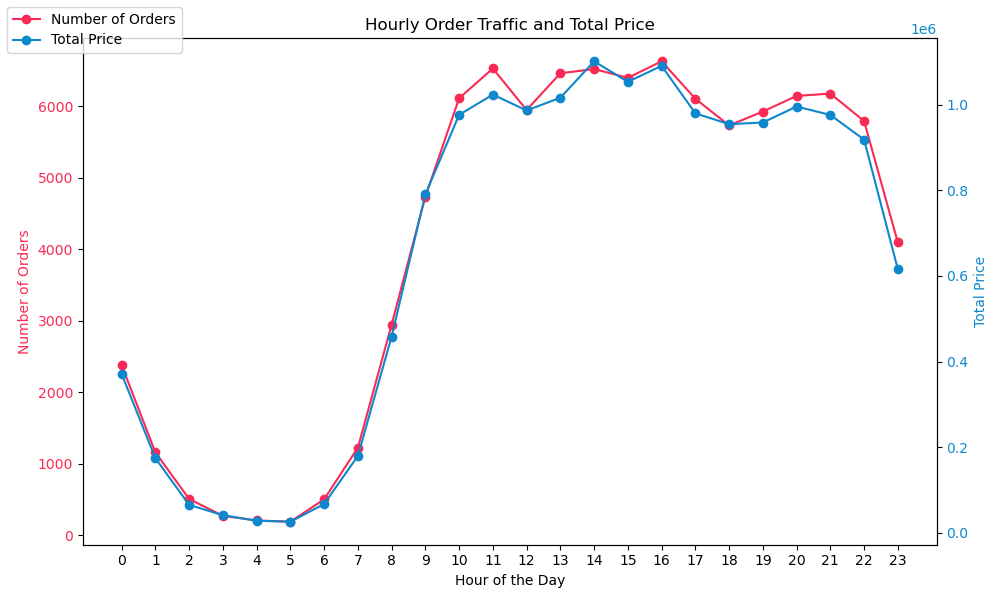

In [35]:
# 将 order_purchase_timestamp 列转换为 datetime 类型
orders_data['order_purchase_timestamp'] = pd.to_datetime(orders_data['order_purchase_timestamp'])

# 从订单购买时间中提取小时信息
orders_data['hour'] = orders_data['order_purchase_timestamp'].dt.hour

# 按小时计算订单数量
hourly_orders = orders_data.groupby('hour').size()

# 按小时计算价格总和
hourly_price = orders_data.groupby('hour')['price'].sum()

# 创建画布和坐标轴
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制订单数量折线图
color = '#fa2a55'
ax1.plot(hourly_orders.index, hourly_orders, marker='o', color=color, label='Number of Orders')
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Number of Orders', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(24))  # 设置x轴刻度为小时

# 在折线上标注数值
# for i, value in enumerate(hourly_orders):
#     ax1.text(i, value, round(value, 2), ha='center', va='bottom')

# 创建第二个坐标轴，共享x轴
ax2 = ax1.twinx()

# 绘制价格总和折线图
color = '#0e87cc'
ax2.plot(hourly_price.index, hourly_price, marker='o', color=color, label='Total Price')
ax2.set_ylabel('Total Price', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# 在折线上标注数值
# for i, value in enumerate(hourly_price):
#     ax2.text(i, value, round(value, 2), ha='center', va='bottom')

# 设置标题和图例
plt.title('Hourly Order Traffic and Total Price')
fig.tight_layout()

# 设置左侧纵轴标签
ax1.set_ylabel('Number of Orders')
# 设置右侧纵轴标签
ax2.set_ylabel('Total Price')

# 显示图例
fig.legend(loc='upper left')

# 显示图形
plt.show()


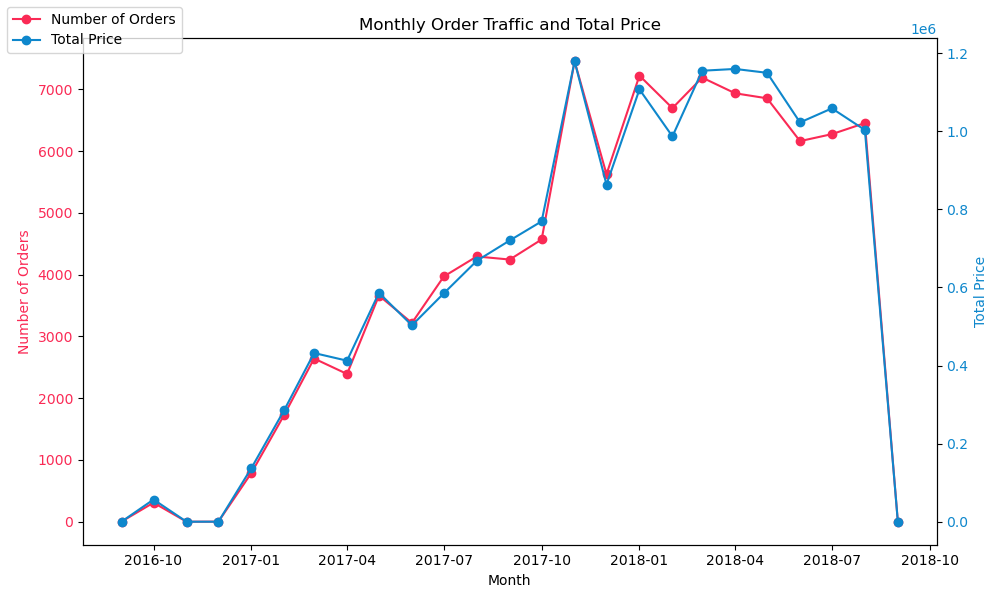

In [10]:

# 将 order_purchase_timestamp 列转换为 datetime 类型并设置为索引
orders_data['order_purchase_timestamp'] = pd.to_datetime(orders_data['order_purchase_timestamp'])
orders_data.set_index('order_purchase_timestamp', inplace=True)

# 按月计算订单数量
monthly_orders = orders_data.resample('MS').size()

# 按月计算价格总和
monthly_price = orders_data.resample('MS')['price'].sum()

# 创建画布和坐标轴
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制订单数量折线图
color = '#fa2a55'
ax1.plot(monthly_orders.index, monthly_orders, marker='o', color=color, label='Number of Orders')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Orders', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# 在折线上标注数值
# for i, value in enumerate(monthly_orders):
#     ax1.text(monthly_orders.index[i], value, round(value, 2), ha='center', va='bottom')

# 创建第二个坐标轴，共享x轴
ax2 = ax1.twinx()

# 绘制价格总和折线图
color = '#0e87cc'
ax2.plot(monthly_price.index, monthly_price, marker='o', color=color, label='Total Price')
ax2.set_ylabel('Total Price', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# # 在折线上标注数值
# for i, value in enumerate(monthly_price):
#     ax2.text(monthly_price.index[i], value, round(value, 2), ha='center', va='bottom')

# 设置标题和图例
plt.title('Monthly Order Traffic and Total Price')
fig.tight_layout()

# 设置左侧纵轴标签
ax1.set_ylabel('Number of Orders')
# 设置右侧纵轴标签
ax2.set_ylabel('Total Price')

# 显示图例
fig.legend(loc='upper left')

# 显示图形
plt.show()


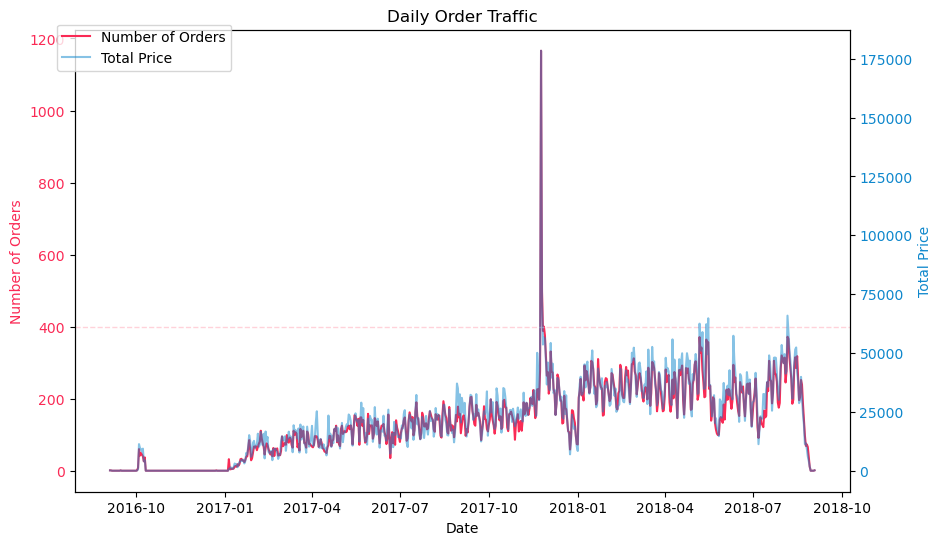

In [11]:
# 按天计算订单数量
daily_orders = orders_data.resample('D').size()

# 按天计算价格总和
daily_price = orders_data.resample('D')['price'].sum()

# 创建画布和坐标轴
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制订单数量折线图
color1 = '#fa2a55'
ax1.plot(daily_orders.index, daily_orders, color=color1, label='Number of Orders')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Orders', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# 添加水平虚线
ax1.axhline(y=400, color='pink', linestyle='--', linewidth=1, alpha=0.7)

# 创建第二个坐标轴，共享x轴
ax2 = ax1.twinx()

# 绘制价格总和折线图
color2 = '#0e87cc'
ax2.plot(daily_price.index, daily_price, color=color2, alpha=0.5, label='Total Price')
ax2.set_ylabel('Total Price', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# 设置标题和网格
plt.title('Daily Order Traffic')
ax1.grid(False)  # 不绘制网格线

# 显示图例
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# 显示图形
plt.show()


In [12]:
daily_orders[daily_orders > 500].index

DatetimeIndex(['2017-11-24'], dtype='datetime64[ns]', name='order_purchase_timestamp', freq='D')

In [13]:
daily_price[daily_price > 75000].index

DatetimeIndex(['2017-11-24'], dtype='datetime64[ns]', name='order_purchase_timestamp', freq='D')

In [14]:
orders_data = pd.merge(items_all, orders, on='order_id', how='inner')
orders_data.head()
# len(orders_data)

,order_id,price,customer_id,order_purchase_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,72.19,3ce436f183e68e07877b285a838db11a,2017/9/13 8:59
1,00018f77f2f0320c557190d7a144bdd3,259.83,f6dd3ec061db4e3987629fe6b26e5cce,2017/4/26 10:53
2,000229ec398224ef6ca0657da4fc703e,216.87,6489ae5e4333f3693df5ad4372dab6d3,2018/1/14 14:33
3,00024acbcdf0a6daa1e931b038114c75,25.78,d4eb9395c8c0431ee92fce09860c5a06,2018/8/8 10:00
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04,58dbd0b2d70206bf40e62cd34e84d795,2017/2/4 13:57


In [15]:
# 将 order_purchase_timestamp 列转换为 datetime 类型
orders_data['order_purchase_timestamp'] = pd.to_datetime(orders_data['order_purchase_timestamp'])

# 去掉所有 order_purchase_timestamp 为 2017-11-24 的行
orders_drop = orders_data[orders_data['order_purchase_timestamp'].dt.date != pd.to_datetime('2017-11-24').date()].copy()

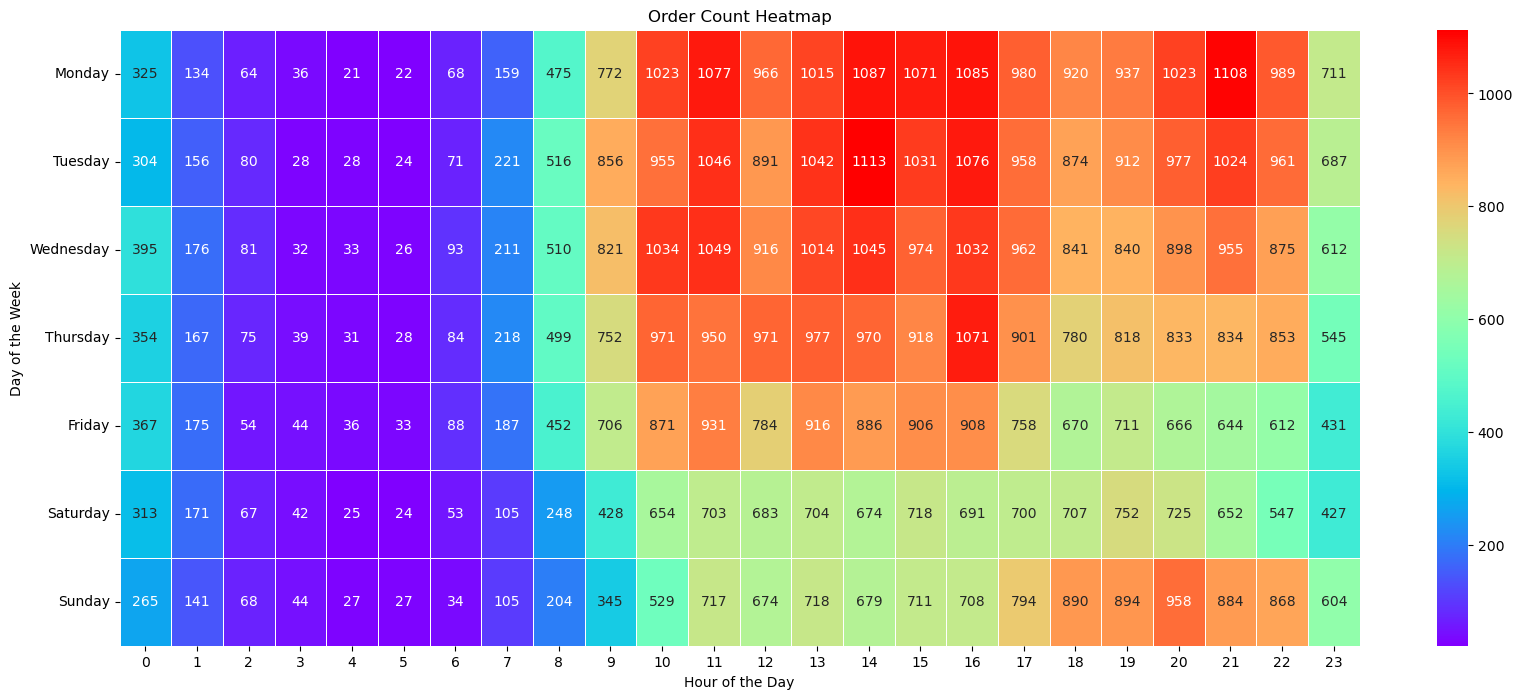

In [16]:
# 提取星期几信息（0代表星期一，6代表星期天），和小时信息
orders_drop['weekday'] = orders_drop['order_purchase_timestamp'].dt.dayofweek
orders_drop['hour'] = orders_drop['order_purchase_timestamp'].dt.hour

# 按星期和小时计算订单数量
orders_drop_count = orders_drop.groupby(['weekday', 'hour']).size().unstack()

# 绘制热力图
plt.figure(figsize=(20, 8))
sns.heatmap(orders_drop_count, cmap="rainbow", annot=True, fmt="d", linewidths=.5)
plt.title('Order Count Heatmap')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.xticks(np.arange(24) + 0.5, range(24))
plt.yticks(np.arange(7) + 0.5, ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=0)
plt.show()


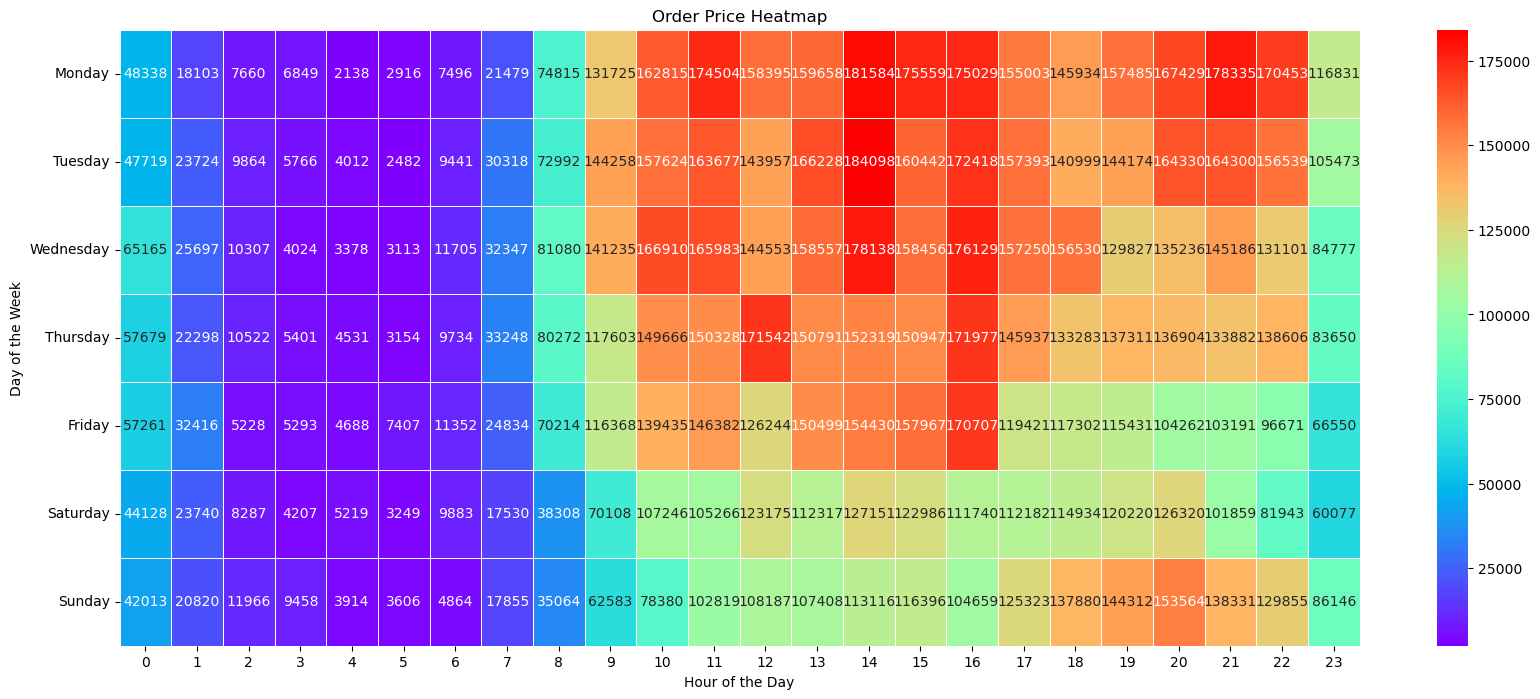

In [17]:
# 提取星期几信息（0代表星期一，6代表星期天），和小时信息
orders_drop['weekday'] = orders_drop['order_purchase_timestamp'].dt.dayofweek
orders_drop['hour'] = orders_drop['order_purchase_timestamp'].dt.hour

# 按星期和小时计算订单金额
orders_drop_price = orders_drop.groupby(['weekday', 'hour'])['price'].sum().unstack()

# 绘制热力图
plt.figure(figsize=(20, 8))
sns.heatmap(orders_drop_price, cmap="rainbow", annot=True, fmt=".0f", linewidths=.5)
plt.title('Order Price Heatmap')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.xticks(np.arange(24) + 0.5, range(24))
plt.yticks(np.arange(7) + 0.5, ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=0)
plt.show()


In [18]:
customers = pd.read_csv('olist_customers_dataset.csv')
customers = customers.drop(customers.columns[[2,3,4]], axis=1)
orders = pd.read_csv('olist_orders_dataset.csv')
orders = orders.drop(orders.columns[[2,4,5,6,7]], axis=1)

In [36]:

# 合并两个 DataFrame，基于 customer_id
customers_orders = pd.merge(orders, customers, on='customer_id')

# 计算每个客户的下单数
customer_order_counts = customers_orders.groupby('customer_unique_id')['order_id'].nunique()

# 计算复购率
reorder_rate = round((customer_order_counts[customer_order_counts > 1].count() / customer_order_counts.count()) * 100, 2)

# 输出复购率
print(f'{reorder_rate}%')
# print(customer_order_counts.describe())

3.12%


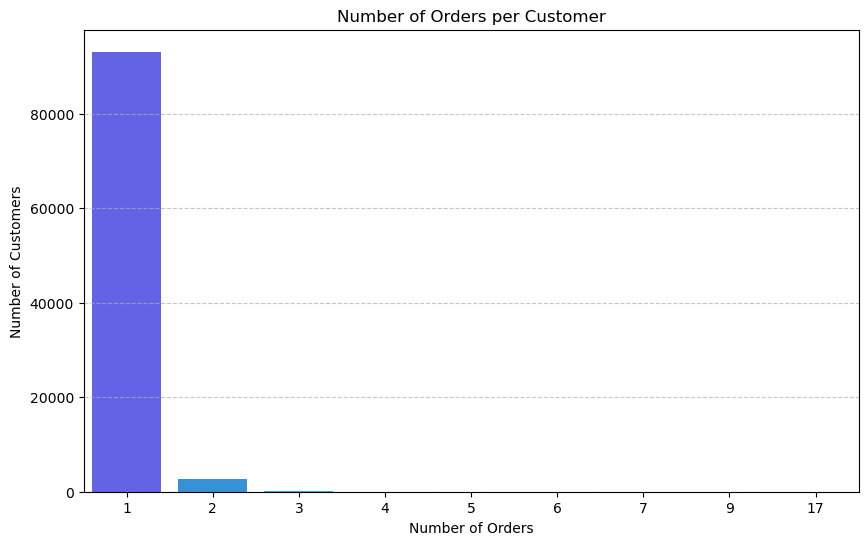

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x=customer_order_counts, palette='rainbow')
plt.title('Number of Orders per Customer')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [21]:
# 从 customers_orders 中选择满足条件的行，并保存到 reorders 中
reorders = customers_orders[customers_orders['customer_unique_id'].isin(customer_order_counts[customer_order_counts > 1].index)].copy()
len(reorders)
reorders.head()

,order_id,customer_id,order_purchase_timestamp,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017/10/2 10:56,7c396fd4830fd04220f754e42b4e5bff
15,dcb36b511fcac050b97cd5c05de84dc3,3b6828a50ffe546942b7a473d70ac0fc,2018/6/7 19:03,ccafc1c3f270410521c3c6f3b249870f
16,403b97836b0c04a622354cf531062e5f,738b086814c6fcc74b8cc583f8516ee3,2018/1/2 19:00,6e26bbeaa107ec34112c64e1ee31c0f5
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,2018/6/4 16:44,08fb46d35bb3ab4037202c23592d1259
46,d17dc4a904426827ca80f2ccb3a6be56,569cf68214806a39acc0f39344aea67f,2017/5/14 20:28,c2551ea089b7ebbc67a2ea8757152514


In [22]:
reorders.to_csv('reorders.csv', index=False)

In [23]:
####################################################################################
##################################### timespan #####################################
####################################################################################
reorders['order_purchase_timestamp'] = pd.to_datetime(reorders['order_purchase_timestamp'])
earliest_order_time = reorders.groupby('customer_unique_id')['order_purchase_timestamp'].min()
latest_order_time = reorders.groupby('customer_unique_id')['order_purchase_timestamp'].max()

# 计算时间差
timespan = (latest_order_time - earliest_order_time).dt.days.copy()
# 去除索引
timespan = timespan.reset_index(drop=True)
print(timespan.describe())

count    2997.000000
mean       86.942943
std       115.572311
min         0.000000
25%         0.000000
50%        33.000000
75%       138.000000
max       633.000000
Name: order_purchase_timestamp, dtype: float64


In [24]:
# 选择大于 0 的数据
timespan = timespan[timespan > 0]
print(timespan.describe())

count    2122.000000
mean      122.793591
std       120.262007
min         1.000000
25%        25.000000
50%        80.000000
75%       189.750000
max       633.000000
Name: order_purchase_timestamp, dtype: float64


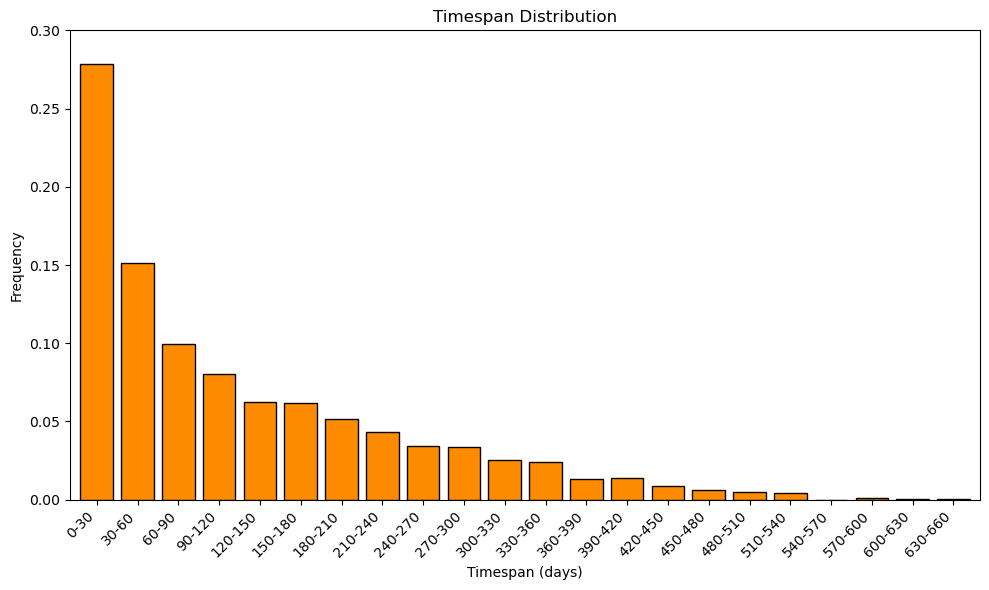

In [25]:
# 计算柱子的范围
bins = range(0, int(timespan.max()) + 30, 30)

# 使用 pandas 的 cut 函数将数据分组，并计算每个范围内的计数
bin_counts = pd.cut(timespan, bins=bins).value_counts().sort_index()

# 计算频率
bin_frequencies = bin_counts / bin_counts.sum()

# 绘制柱状图
plt.figure(figsize=(10, 6))
bin_frequencies.plot(kind='bar', width=0.8, color='#FF8C00', edgecolor='black')
plt.title('Timespan Distribution')
plt.xlabel('Timespan (days)')
plt.ylabel('Frequency')
plt.ylim(0, 0.3)
plt.xticks(rotation=45, ha='right')
plt.gca().set_xticklabels([f'{int(b.left)}-{int(b.right)}' for b in bin_counts.index], rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [26]:
# 获取出现过复购行为的顾客的订单数据
reorders = customers_orders[customers_orders['customer_unique_id'].isin(customer_order_counts[customer_order_counts > 1].index)].copy()

# 将订单时间转换为 datetime 类型
reorders['order_purchase_timestamp'] = pd.to_datetime(reorders['order_purchase_timestamp'])

# 按照 customer_unique_id 分组，计算每个顾客的订单时间，并取最早和第二早的时间
earliest_order_time = reorders.groupby('customer_unique_id')['order_purchase_timestamp'].min()
second_earliest_order_time = reorders.groupby('customer_unique_id')['order_purchase_timestamp'].apply(lambda x: x.nsmallest(2).iloc[-1])

# 计算时间差
timediff = (second_earliest_order_time - earliest_order_time).dt.days
timediff.describe()

count    2997.000000
mean       79.991325
std       110.088864
min         0.000000
25%         0.000000
50%        27.000000
75%       123.000000
max       608.000000
Name: order_purchase_timestamp, dtype: float64

In [27]:
timediff = timediff[timediff > 0]
print(timediff.describe())

count    2070.000000
mean      115.813527
std       115.753768
min         1.000000
25%        23.250000
50%        74.000000
75%       179.000000
max       608.000000
Name: order_purchase_timestamp, dtype: float64


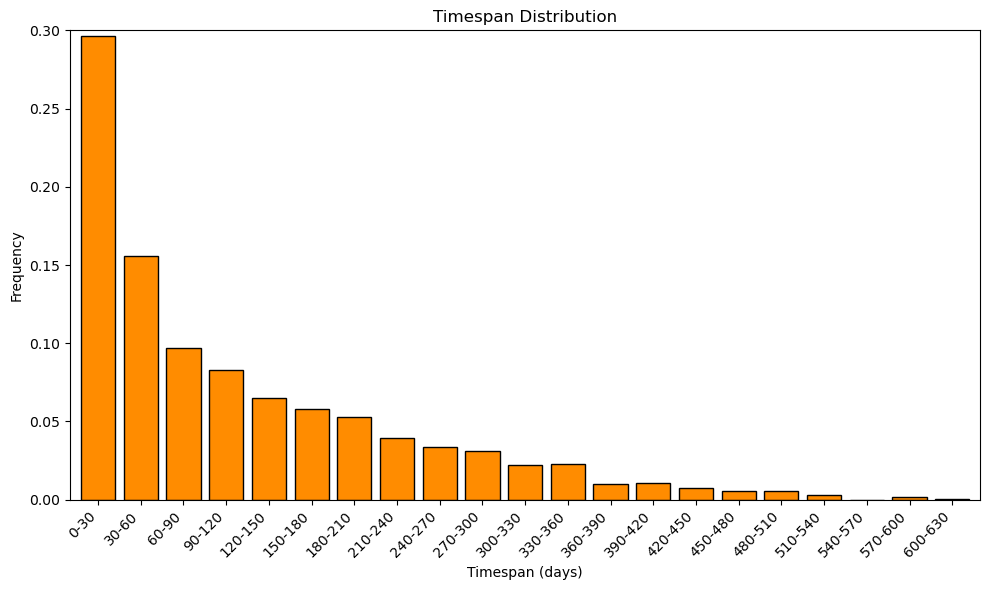

In [28]:
# 计算柱子的范围
bins = range(0, int(timediff.max()) + 30, 30)

# 使用 pandas 的 cut 函数将数据分组，并计算每个范围内的计数
bin_counts = pd.cut(timediff, bins=bins).value_counts().sort_index()

# 计算频率
bin_frequencies = bin_counts / bin_counts.sum()

# 绘制柱状图
plt.figure(figsize=(10, 6))
bin_frequencies.plot(kind='bar', width=0.8, color='#FF8C00', edgecolor='black')
plt.title('Timespan Distribution')
plt.xlabel('Timespan (days)')
plt.ylabel('Frequency')
plt.ylim(0, 0.3)
plt.xticks(rotation=45, ha='right')
plt.gca().set_xticklabels([f'{int(b.left)}-{int(b.right)}' for b in bin_counts.index], rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [29]:
# 统计每个 customer_unique_id 出现的次数
customer_counts = customers_orders['customer_unique_id'].value_counts()

# 计算出现两次的 customer_unique_id 的数量
two_time_customers_count = sum(customer_counts == 2)

# 计算出现两次的 customer_unique_id 占所有出现次数大于等于2的 customer_unique_id 的比例
two_time_ratio = two_time_customers_count / sum(customer_counts >= 2)

print("进行2次购买后不继续进行购买的比例：{:.2f}".format(two_time_ratio * 100), "%")



# 计算出现三次的 customer_unique_id 的数量
three_time_customers_count = sum(customer_counts == 3)

# 计算出现三次的 customer_unique_id 占所有出现次数大于等于2的 customer_unique_id 的比例
three_time_ratio = three_time_customers_count / sum(customer_counts >= 3)

print("进行3次购买后不继续进行购买的比例：{:.2f}".format(three_time_ratio * 100), "%")

进行2次购买后不继续进行购买的比例：91.59 %
进行3次购买后不继续进行购买的比例：80.56 %


In [30]:
customers_contribution = pd.merge(orders_data, customers, on='customer_id').copy()
customers_contribution = customers_contribution.drop(customers_contribution.columns[[0,2,3]], axis=1)
customers_contribution.head()
print(len(customers_contribution))
customers_contribution.head()

98666


,price,customer_unique_id
0,72.19,871766c5855e863f6eccc05f988b23cb
1,259.83,eb28e67c4c0b83846050ddfb8a35d051
2,216.87,3818d81c6709e39d06b2738a8d3a2474
3,25.78,af861d436cfc08b2c2ddefd0ba074622
4,218.04,64b576fb70d441e8f1b2d7d446e483c5


In [31]:
customers_contribution_sum = customers_contribution.groupby('customer_unique_id').sum().reset_index()
customers_contribution_sum = customers_contribution_sum.sort_values(by='price', ascending=False).reset_index(drop=True)
print(len(customers_contribution_sum))
customers_contribution_sum.head()

95420


,customer_unique_id,price
0,0a0a92112bd4c708ca5fde585afaa872,13664.08
1,da122df9eeddfedc1dc1f5349a1a690c,7571.63
2,763c8b1c9c68a0229c42c9fc6f662b93,7274.88
3,dc4802a71eae9be1dd28f5d788ceb526,6929.31
4,459bef486812aa25204be022145caa62,6922.21


In [32]:
# 计算累计百分比
customers_contribution_sum['accumulated_number'] = customers_contribution_sum.index / len(customers_contribution_sum)
customers_contribution_sum['accumulated_sales'] = customers_contribution_sum['price'].cumsum() / customers_contribution_sum['price'].sum()
customers_contribution_sum = customers_contribution_sum.drop(customers_contribution_sum.columns[[0]], axis=1)
customers_contribution_sum.tail()


,price,accumulated_number,accumulated_sales
95415,11.63,0.999948,0.999997
95416,11.63,0.999958,0.999998
95417,10.89,0.999969,0.999999
95418,10.07,0.999979,0.999999
95419,9.59,0.999990,1.000000


In [33]:
nearest_row = customers_contribution_sum.iloc[(customers_contribution_sum['accumulated_sales']-0.8).abs().argsort()[:1]]
nearest_row

,price,accumulated_number,accumulated_sales
46505,111.21,0.487372,0.800001


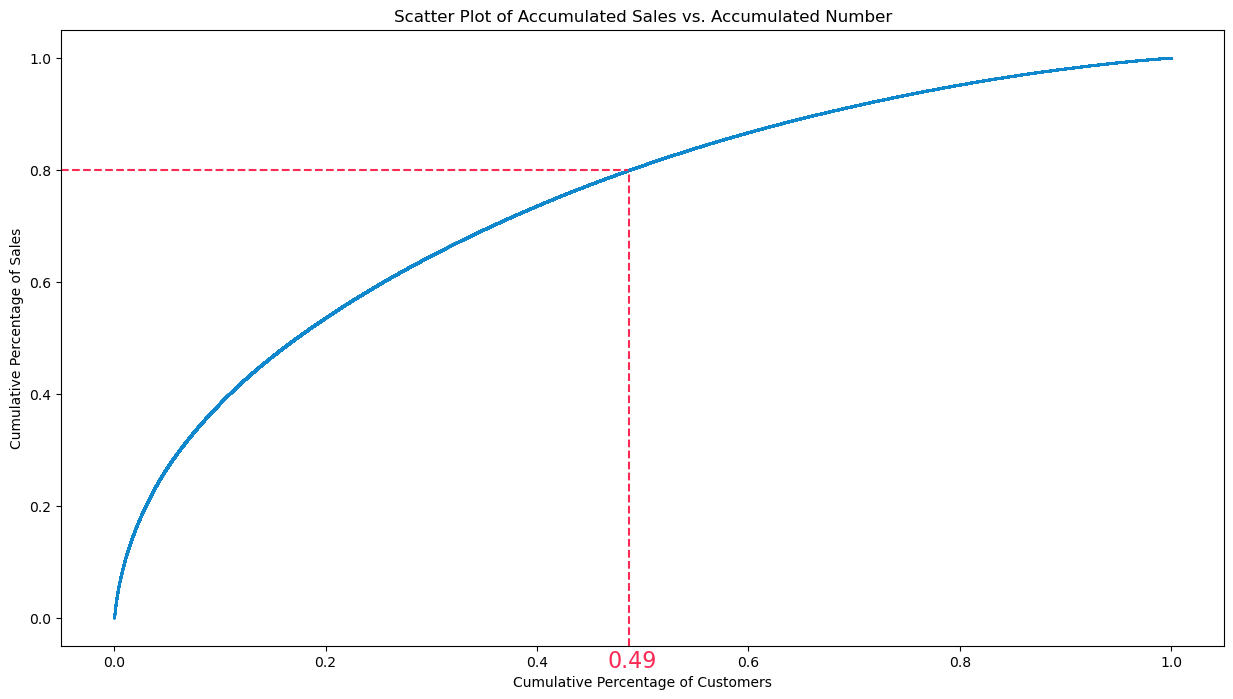

In [34]:
# 设置画布大小
plt.figure(figsize=(15, 8))

# 绘制散点图
plt.scatter(customers_contribution_sum['accumulated_number'], customers_contribution_sum['accumulated_sales'], s=1,color = '#0e87cc')

# 设置标题和标签
plt.title('Scatter Plot of Accumulated Sales vs. Accumulated Number')
plt.xlabel('Cumulative Percentage of Customers')
plt.ylabel('Cumulative Percentage of Sales')

# 绘制横虚线
plt.axhline(y=0.8,xmax=0.487372, color='#fa2a55', linestyle='--')

# 绘制竖虚线
plt.axvline(x=0.487372, ymax=0.77, color='#fa2a55', linestyle='--')

# 在横坐标下方标注横坐标值
plt.text(0.49, -0.088, '0.49', color='#fa2a55', ha='center', fontsize=16)

# 显示图形
plt.show()